In [1]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity
using StatsBase
using Random 

Random.seed!(1234);

 Activating environment at `~/hypergraph_modularities_code/Project.toml`
┌ Info: Precompiling HypergraphModularity [0c934d27-dd44-49d7-950f-bd4be7819e54]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphModularity does not have DelimitedFiles in its dependencies:
│ - If you have HypergraphModularity checked out for development and have
│   added DelimitedFiles as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphModularity
└ Loading DelimitedFiles into HypergraphModularity from project dependency, future warnings for HypergraphModularity are suppressed.


In [2]:
datasets = Dict(
    "email-Enron-full" => Dict("kmax" => 10, 
                               "prune" => false,
                               "haslabels" => false),
    "contact-primary-school-classes" => Dict("kmax" => 6,
                                             "prune" => false,
                                             "haslabels" => true),
    "TrivagoClickout" => Dict("kmax" => 10,
                              "prune" => 2,
                              "haslabels" => true),
    "walmart-trips" => Dict("kmax" => 10,
                              "prune" => 2,
                              "haslabels" => true)
)

Dict{String,Dict{String,Integer}} with 4 entries:
  "TrivagoClickout"                => Dict{String,Integer}("haslabels"=>true,"k…
  "email-Enron-full"               => Dict{String,Integer}("haslabels"=>false,"…
  "contact-primary-school-classes" => Dict{String,Integer}("haslabels"=>true,"k…
  "walmart-trips"                  => Dict{String,Integer}("haslabels"=>true,"k…

In [3]:
function prep_data(dataset)
    
    # check if there are labels, and read in the data
    haslabels = datasets[dataset]["haslabels"]
    kmax = datasets[dataset]["kmax"]
    if haslabels
        H, Z = read_hypergraph_data(dataset,kmax, 2, true)
    else
        H = read_hypergraph_data(dataset,kmax, 2, false)
        Z = nothing
    end
    
    # prune the data if specified
    d = datasets[dataset]["prune"]
    if d > 0
        for i in 1:10
            H, Z = subHypergraph(H, H.D .>= d, Z)
        end
    end
    if haslabels
        return H, Z
    end
    return H
end;

In [4]:
# these values of ωᵢ and ωₒ are roughly tuned so that 
# the effective resolution parameter is unity. 
# Then, the multiplier controls the overall resolution parameter

ωᵢ = 2.0
ωₒ = 0.6

function acquirePartition(H; verbose = false, n_iters = 10, γ = 1000)

    function ω(p, α)
        num = p[1] == 1 ? ωᵢ : ωₒ
        denom = big(sum(H.D))^sum(p[2])
        return γ*num / denom
    end

    Ω̂₀ = allOrNothingIntensityFunction(ω, maximum(keys(H.E)));
    n = length(H.D)
    Ẑ = nothing
    best_Ẑ = nothing
    best_Q = -Inf
    T = Vector{Float64}()
    for i ∈ 1:n_iters
        Ẑ, t = @timed SuperNode_PPLouvain(H, Ω̂₀; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
        Ω̂₀ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
        Q = modularity(H, Ẑ, Ω̂₀; α = nothing)
        k = length(unique(Ẑ))
        penalty = round( - n * log(k))
        if verbose
            println(round(Q), "    ", penalty , "   ", round(Q + penalty),"    ", k, "    ", t)
        end
        if Q + penalty > best_Q
            best_Q = Q + penalty
            best_Ẑ = Ẑ
        end
        push!(T, t)
    end
    
    return best_Ẑ, Ω̂₀, mean(T)
end

acquirePartition (generic function with 1 method)

In [5]:
A = Vector{Float64}()
O = Vector{String}()
D = Vector{String}()
K = Vector{Int64}()

function compare_Ω(H, Ẑ; data_label = "")
        
    kmax = maximum(keys(H.E))
    kmin = minimum(keys(H.E))
    n = length(H.D)
    
    function ω_m(p, α)
        k = big(sum(p))
        kmax = length(α) ÷ 2
        return k/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
    end

    function ω_d(p, α)
        k = big(sum(p))
        kmax = length(α) ÷ 2
        dcut = big((sum(p*p') - p'*p)/2)
        return k/((1 + dcut)^α[k])/ n^(α[kmax+k]*k)
    end
    
    num_parameters = 0
    for aff in ["AON", "numGroups", "dyadic", "majorization"]
        print(rpad(aff, 15))
        α = vcat(repeat([1.0], kmax), 1:kmax);
        if aff == "AON"
            Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true)
            num_parameters = 2*(kmax - kmin)
        elseif aff == "numGroups"
            Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p), sum(p)], bigNums = true)
            num_parameters = kmax*(kmax - 1)/2 - kmin*(kmin-1)/2
        elseif aff == "dyadic"
            Ω̂ = partitionIntensityFunction(ω_d, kmax)
            α = learnParameters(H, Ẑ, Ω̂, α; max_iters = 50, verbose = false)
            num_parameters = 2*(kmax - kmin)
        elseif aff == "majorization"
            Ω̂ = partitionIntensityFunction(ω_m, kmax)
            α = learnParameters(H, Ẑ, Ω̂, α; max_iters = 50, verbose = false) 
            num_parameters = 2*(kmax - kmin)
        end
        
        for i in 1:2kmax push!(O, aff) end
        for i in 1:2kmax push!(A, α[i]) end
        for i in 1:2kmax push!(D, data_label) end
        for i in 1:2kmax push!(K, i) end
        
        
        AIC = 2*modularity(H, Ẑ, Ω̂; α = α) - 2*num_parameters
        print(rpad(Float64(AIC), 30))
        
        N   = sum(big(n)^k/factorial(k) for k in kmin:kmax) # number of observations, very large
        BIC = 2*modularity(H, Ẑ, Ω̂; α = α) - num_parameters*log(N)
        println(rpad(Float64(BIC), 30))
    end
end

compare_Ω (generic function with 1 method)

In [6]:
H, Z = prep_data("contact-primary-school-classes")
Ẑ, Ω̂₀, T = acquirePartition(H; verbose = false, n_iters = 20, γ = 10000);
println("Number of nodes: $(length(H.D))")
println("Mean Louvain Runtime: $(round(T, digits=2))s")
println("Number of groups: $(length(unique(Ẑ)))")
println("Mean degree: $(mean(H.D))")

num = sum(sum(collect(values(H.E[k])))*k for k in keys(H.E) if length(H.E[k]) > 0)
denom = sum(sum(collect(values(H.E[k]))) for k in keys(H.E) if length(H.E[k]) > 0)

mean_k = num/denom

println("Mean edge size: $(mean_k)")
println("")
print(rpad("Ω", 15))
print(rpad("AIC", 30))
println(rpad("BIC", 30))
println(rpad("", 50, "-"))
compare_Ω(H, Ẑ; data_label = "contact-primary-school")

Number of nodes: 242
Mean Louvain Runtime: 0.13s
Number of groups: 7
Mean degree: 126.97933884297521
Mean edge size: 2.4188444584382873

Ω              AIC                           BIC                           
--------------------------------------------------
AON            -416554.82284326176           -416720.2467329968            
numGroups      -415401.5608442435            -415608.3407064122            
dyadic         -415613.23016189336           -415778.6540516283            
majorization   -415561.03799726866           -415726.4618870036            


In [7]:
H = prep_data("email-Enron-full");
Ẑ, Ω̂₀, T = acquirePartition(H; verbose = false, n_iters = 20);
println("Number of nodes: $(length(H.D))")
println("Mean Louvain Runtime: $(round(T, digits=2))s")
println("Number of groups: $(length(unique(Ẑ)))")
println("Mean degree: $(mean(H.D))")

num = sum(sum(collect(values(H.E[k])))*k for k in keys(H.E) if length(H.E[k]) > 0)
denom = sum(sum(collect(values(H.E[k]))) for k in keys(H.E) if length(H.E[k]) > 0)

mean_k = num/denom

println("Mean edge size: $(mean_k)")

println("")
print(rpad("Ω", 15))
print(rpad("AIC", 20))
println(rpad("BIC", 20))
println(rpad("", 50, "-"))
compare_Ω(H, Ẑ; data_label = "email-Enron-full")

Number of nodes: 148
Mean Louvain Runtime: 0.02s
Number of groups: 11
Mean degree: 28.533783783783782
Mean edge size: 2.9408077994428967

Ω              AIC                 BIC                 
--------------------------------------------------
AON            -52310.21059189935            -52903.07932351048            
numGroups      -51882.06999165356            -53364.241820681375           
dyadic         -51980.587020204526           -52573.45575181565            
majorization   -51836.72702906432            -52429.595760675445           


In [8]:
H, Z = prep_data("TrivagoClickout");
Ẑ, Ω̂₀, T = acquirePartition(H; verbose = false, n_iters = 20);
println("Number of nodes: $(length(H.D))")
println("Mean Louvain Runtime: $(round(T, digits=2))s")
println("Number of groups: $(length(unique(Ẑ)))")
println("Mean degree: $(mean(H.D))")

num = sum(sum(collect(values(H.E[k])))*k for k in keys(H.E) if length(H.E[k]) > 0)
denom = sum(sum(collect(values(H.E[k]))) for k in keys(H.E) if length(H.E[k]) > 0)

mean_k = num/denom

println("Mean edge size: $(mean_k)")

println("")
print(rpad("Ω", 15))
print(rpad("AIC", 30))
println(rpad("BIC", 30))
println(rpad("", 50, "-"))
compare_Ω(H, Ẑ; data_label = "TrivagoClickout")

Number of nodes: 71558
Mean Louvain Runtime: 44.99s
Number of groups: 721
Mean degree: 7.9751250733670584
Mean edge size: 3.7895030412494357

Ω              AIC                           BIC                           
--------------------------------------------------
AON            -8.619255415113937e6          -8.620770268923027e6          
numGroups      -8.36324592325583e6           -8.367411771230826e6          
dyadic         -8.501289219347347e6          -8.502804073156435e6          
majorization   -8.371104265810004e6          -8.372619119619094e6          


In [13]:
H, Z = prep_data("TrivagoClickout");
Ẑ = Z
println("Number of nodes: $(length(H.D))")
println("Mean Louvain Runtime: $(round(T, digits=2))s")
println("Number of groups: $(length(unique(Ẑ)))")
println("Mean degree: $(mean(H.D))")

num = sum(sum(collect(values(H.E[k])))*k for k in keys(H.E) if length(H.E[k]) > 0)
denom = sum(sum(collect(values(H.E[k]))) for k in keys(H.E) if length(H.E[k]) > 0)

mean_k = num/denom

println("Mean edge size: $(mean_k)")

println("")
print(rpad("Ω", 15))
print(rpad("AIC", 30))
println(rpad("BIC", 30))
println(rpad("", 50, "-"))
compare_Ω(H, Ẑ; data_label = "TrivagoClickout-TrueLabels")

Number of nodes: 71558
Mean Louvain Runtime: 12.55s
Number of groups: 123
Mean degree: 7.9751250733670584
Mean edge size: 3.7895030412494357

Ω              AIC                           BIC                           
--------------------------------------------------
AON            -1.0234086860862033e7         -1.0235601714671122e7         
numGroups      -1.0212394437538821e7         -1.0216560285513816e7         
dyadic         -1.0220536373573827e7         -1.0222051227382917e7         
majorization   -1.0212565082809113e7         -1.0214079936618201e7         


In [9]:
H, Z = prep_data("walmart-trips");
Ẑ, Ω̂₀, T = acquirePartition(H; verbose = false, n_iters = 20, γ = 50000);
println("Number of nodes: $(length(H.D))")
println("Mean Louvain Runtime: $(round(T, digits=2))s")
println("Number of groups: $(length(unique(Ẑ)))")
println("Mean degree: $(mean(H.D))")

num = sum(sum(collect(values(H.E[k])))*k for k in keys(H.E) if length(H.E[k]) > 0)
denom = sum(sum(collect(values(H.E[k]))) for k in keys(H.E) if length(H.E[k]) > 0)

mean_k = num/denom

println("Mean edge size: $(mean_k)")

println("")
print(rpad("Ω", 15))
print(rpad("AIC", 30))
println(rpad("BIC", 30))
println(rpad("", 50, "-"))
compare_Ω(H, Ẑ; data_label = "walmart-trips")

Number of nodes: 9300
Mean Louvain Runtime: 12.55s
Number of groups: 9
Mean degree: 5.558817204301075
Mean edge size: 3.48879740855716

Ω              AIC                           BIC                           
--------------------------------------------------
AON            -885957.2725986973            -887145.6623578946            
numGroups      -883555.7668942276            -886823.8387320199            
dyadic         -884566.4334000557            -885754.823159253             
majorization   -886989.6130075895            -888178.0027667867            


In [14]:
H, Z = prep_data("walmart-trips");
Ẑ = Z
println("Number of nodes: $(length(H.D))")
println("Mean Louvain Runtime: $(round(T, digits=2))s")
println("Number of groups: $(length(unique(Ẑ)))")
println("Mean degree: $(mean(H.D))")

num = sum(sum(collect(values(H.E[k])))*k for k in keys(H.E) if length(H.E[k]) > 0)
denom = sum(sum(collect(values(H.E[k]))) for k in keys(H.E) if length(H.E[k]) > 0)

mean_k = num/denom

println("Mean edge size: $(mean_k)")

println("")
print(rpad("Ω", 15))
print(rpad("AIC", 30))
println(rpad("BIC", 30))
println(rpad("", 50, "-"))
compare_Ω(H, Ẑ; data_label = "walmart-trips-TrueLabels")

Number of nodes: 9300
Mean Louvain Runtime: 12.55s
Number of groups: 11
Mean degree: 5.558817204301075
Mean edge size: 3.48879740855716

Ω              AIC                           BIC                           
--------------------------------------------------
AON            -911223.6692942963            -912412.0590534935            
numGroups      -910066.0788825046            -913334.1507202969            
dyadic         -910793.6721966654            -911982.0619558627            
majorization   -910662.9911829687            -911851.380942166             


In [10]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 650, :height => 300))

R"""
library(tidyverse)
library(viridis)
"""

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.3     ✔ dplyr   1.0.0
│ ✔ tidyr   1.1.0     ✔ stringr 1.4.0
│ ✔ readr   1.3.1     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: viridisLite
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{StrSxp}
 [1] "viridis"     "viridisLite" "forcats"     "stringr"     "dplyr"      
 [6] "purrr"       "readr"       "tidyr"       "tibble"      "ggplot2"    
[11] "tidyverse"   "stats"       "graphics"    "grDevices"   "utils"      
[16] "datasets"    "methods"     "base"       


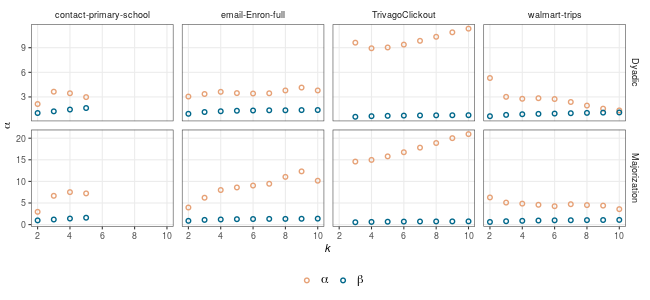

RObject{VecSxp}


In [11]:
D = convert(Array{String, 1}, D)
O = convert(Array{String, 1}, O)
A = convert(Array{Float64, 1}, A)
R"""
df <- tibble(dataset = $D, 
             alpha = $A, 
             omega = $O)

df %>% 
    filter(omega %in% c("dyadic", "majorization")) %>% 
    group_by(dataset, omega) %>% 
    mutate(k = row_number(),
           kmax = max(k)/2,
           type = k > kmax,
           k = ifelse(k > kmax, k - kmax, k),
           k = ifelse((dataset == "TrivagoClickout") & (k == 2), NA, k)) %>% 
    mutate(omega = stringr::str_to_title(omega)) %>% 
    filter(k >= 2) %>% 
    ggplot() + 
    aes(x = k, y = alpha, color = type) +
    geom_point(pch = 21, stroke = 1) + 
    facet_grid(omega~dataset, scales = "free_y") + 
    theme_bw() + 
    scale_color_manual(labels = c(expression(alpha), expression(beta)), values = c("#e6a176","#00678a" )) + 
    guides(color = guide_legend(title = element_blank())) + 
    ylab(expression(alpha)) + 
    xlab(expression(italic(k))) + 
    theme(strip.background = element_blank(),
          panel.spacing = unit(3, "mm"),
          strip.text = element_text(size = 9),
          legend.position = "bottom",
          legend.text = element_text(size = 12),
          panel.grid.minor = element_blank())
"""

In [12]:
R"""
ggsave("fig/omega.png", width = 6.5, height = 3.5)
"""

RObject{NilSxp}
NULL
